---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>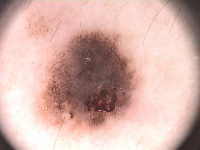</td><td>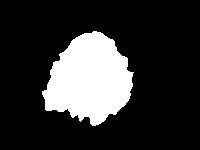</td></tr></table>

2. Разархивируем .rar файл.

Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [119]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2024-11-24 11:49:44--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2024-11-24 11:49:44--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc046897cb7517f3e6658b821447.dl.dropboxusercontent.com/cd/0/inline/Ce-4xdhpC-gPimKmvv6bo9dDg8GFVc407C5ayEpXctnJXT4bTze_-hjdLOv-qt6xEQLbv6HvPTeHhIHBdlxUMF0oQTuEFz0uAHbvT4MBUWsDRgSi45gTAXskw0c35HesOvo/file# [following]
--2024-11-24 11:49:44--  https://uc046897cb7517f3e6658b821447.dl.dropboxusercontent.com/cd/0/inline/Ce-4xdhpC-gPi

In [ ]:
!ls

PH2Dataset  PH2Dataset.rar  sample_data


In [120]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [121]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [171]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [172]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [173]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

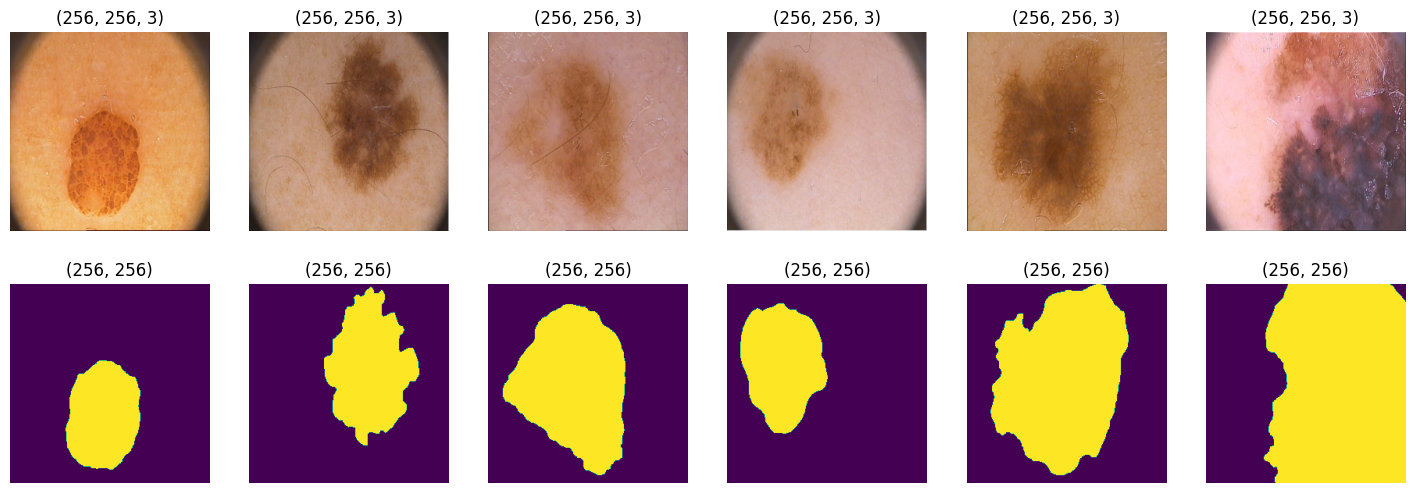

In [174]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.title(X[i].shape)
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.title(Y[i].shape)
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [175]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [176]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [177]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [178]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

## Тренировка

In [234]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode

        torch.cuda.empty_cache()

        for X_batch, Y_batch in data_tr:
            # data to device
            # set parameter gradients to zero
            opt.zero_grad()
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # forward
            Y_pred = model(X_batch)

            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()

        clear_output(wait=True)
        for k in range(min(6, X_val.size(0))):  # Ограничение максимального количества изображений
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597)


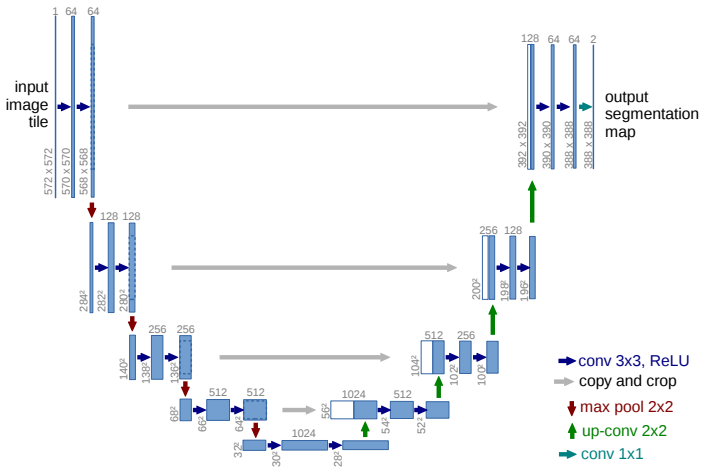

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, stride=2)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2, stride=2)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2, stride=2)  # 32 -> 16


        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.Upsample(scale_factor = 2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.Upsample(scale_factor = 2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.Upsample(scale_factor = 2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size = 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)  # 256 -> 256
        e1 = self.enc_conv1(self.pool0(e0)) # 256 -> 128
        e2 = self.enc_conv2(self.pool1(e1)) # 128 -> 64
        e3 = self.enc_conv3(self.pool2(e2)) # 64 -> 32

        # bottleneck
        b = self.upsample0(self.bottleneck_conv(self.pool0(e3))) # 32 -> 16 -> 32

        # decoder
        d0 = self.dec_conv0(torch.cat([e3, b], 1)) # concat 32 + 32
        d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], 1)) # concat 64 + 64
        d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], 1)) # concat 128 + 128
        d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], 1)) # concat 256 + 256
        return d3

In [ ]:
unet_model = UNet().to(device)
bce_loss = nn.BCEWithLogitsLoss()

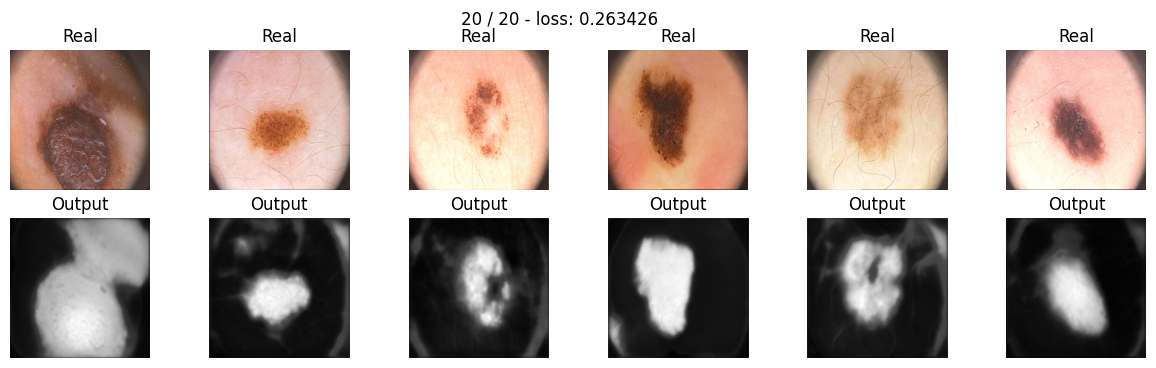

In [ ]:
torch.cuda.empty_cache()
train(unet_model, torch.optim.AdamW(unet_model.parameters(), lr = 1e-4, weight_decay=0.01), bce_loss, 20, data_tr, data_val)

UNet++ [Статья](https://arxiv.org/pdf/1807.10165)
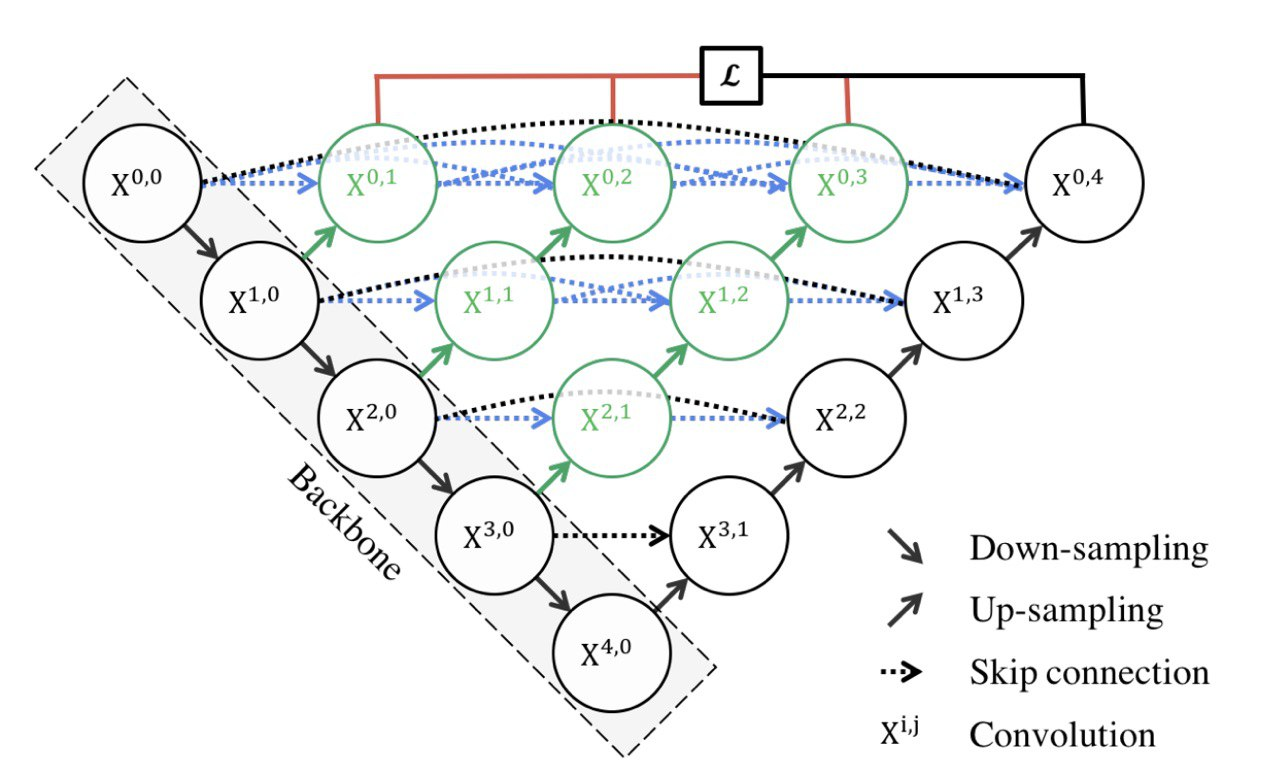

In [226]:
import torch
import torch.nn as nn

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNetPlusPlus, self).__init__()

        # Encoder
        self.enc0 = self.conv_block(in_channels, 64) # 256
        self.pool0 = nn.MaxPool2d(kernel_size=2) # 256 -> 128

        self.enc1 = self.conv_block(64, 128) # 128
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64

        self.enc2 = self.conv_block(128, 256) # 64
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32

        self.enc3 = self.conv_block(256, 512) # 32
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        self.bottleneck = self.conv_block(512, 1024)

        # Nested blocks for UNet++
        self.nest01 = self.conv_block(64 + 128, 64)
        self.nest02 = self.conv_block(64 + 128, 64)
        self.nest03 = self.conv_block(64 + 128, 64)
        self.nest11 = self.conv_block(128 + 256, 128)
        self.nest12 = self.conv_block(128 + 256, 128)
        self.nest21 = self.conv_block(256 + 512, 256)

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up0 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        self.dec3 = self.conv_block(1024 + 512, 512)
        self.dec2 = self.conv_block(256 + 512, 256)
        self.dec1 = self.conv_block(128 + 256, 128)
        self.dec0 = self.conv_block(64 + 128, 64)

        # Final output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        e0 = self.enc0(x) # 256
        e1 = self.enc1(self.pool0(e0)) # 128
        e2 = self.enc2(self.pool1(e1)) # 64
        e3 = self.enc3(self.pool2(e2)) # 32

        # Bottleneck
        b = self.up3(self.bottleneck(self.pool3(e3))) # 32 -> 16 -> 32

        # Nested Skip Connections
        d3 = self.dec3(torch.cat([e3, b], dim = 1))  # 32 -> 32 (512)
        #print(d3[0][0].shape)
        nest2 = self.nest21(torch.cat([e2, self.up3(e3)], 1)) # e2 (64) + up3(e3) from 32 to 64 --> 64x64 (256 kernel_size)
        d2 = self.dec2(torch.cat([nest2, self.up2(d3)], dim=1)) # nest2 (64x64 256 kernel_size) + up2(d3) (64x64 512 kernel_size) --> 64x64 256 kernel_size
        #print(d2[0][0].shape)
        nest1_1 = self.nest11(torch.cat([e1, self.up2(e2)], 1)) # e1 (128) + up2(e2) from 64 to 128 --> 128x128 (128 kernel_size)
        nest1_2 = self.nest12(torch.cat([nest1_1, self.up2(nest2)], 1)) # nest1_1 (128x128 128 kernel_size) + up2(nest3) from 64 to 128  - 128x128 (256 kernel_size) --> 128x128 128 kernel_size
        d1 = self.dec1(torch.cat([nest1_2, self.up1(d2)], dim=1)) # nest1_2 (128x128 128 kernel_size) + up1(d2) (128x128 256 kernel_size) --> 128x128 128 kernel_size
        #print(d1[0][0].shape)
        nest0_1 = self.nest01(torch.cat([e0, self.up0(e1)], 1)) # e0 (256) + up0(e1) from 128 to 256 --> 256x256 (64 kernel_size)
        nest0_2 = self.nest02(torch.cat([nest0_1, self.up0(nest1_1)], 1)) # nest0_1 (64 kernel 256x256) + up0(nest1_1) from 128 to 256 - 256x256 (128 kernel_size) --> 256x256 (64 + 128 kernel_size)
        nest0_3 = self.nest03(torch.cat([nest0_2, self.up0(nest1_2)], 1)) # nest0_2 (64 kernel 256x256) + up0(nest1_2) from 128 to 256 - 256x256 (128 kernel_size) --> 256x256 (64 + 128 kernel_size)
        d0 = self.dec0(torch.cat([nest0_3, self.up0(d1)], dim=1)) # nest0_3 (256x256 64 kernel_size) + up0(d1) (256x256 128 kernel_size) --> 256x256 64 kernel_size
        #print(d0[0][0].shape)
        # Final output
        fc = self.final_conv(d0)
        #print(fc[0][0].shape)
        return self.final_conv(d0) # 256x256 64 kernel_size --> 256x256 1 kernel_size


In [ ]:

!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=f1f0ebc9cfcc57fa38e0d729d107bcaebe1a2c4555b67b03439cefd2258bde3a
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [237]:
from GPUtil import showUtilization as gpu_usage

# давай-ка теперь почистим наш ГПУ!
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% | 51% |


In [236]:
import gc
# опять какие-остатки остались :(
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% | 51% |


In [238]:
unet_model_pp = UNetPlusPlus().to(device)
bce_loss = nn.BCEWithLogitsLoss()

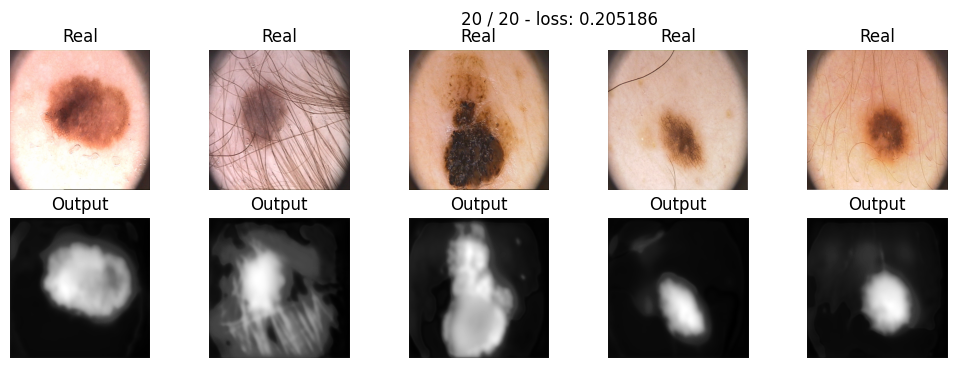

In [239]:
torch.cuda.empty_cache()
train(unet_model_pp, torch.optim.AdamW(unet_model_pp.parameters(), lr = 1e-4, weight_decay=0.01), bce_loss, 20, data_tr, data_val)